# Homework - Neural networks - Part E (50 points)
## Discovering lexical classes from simple sentences

by *Brenden Lake* and *Todd Gureckis*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  

<div class="alert alert-danger" role="alert">
This homework is due before midnight on Monday, Feb. 13, 2023.
</div>

In this assignment, you will follow in Elman's (1990) footsteps by coding and training a Simple Recurrent Network (SRN) on a set of simple sentences. 
- **Before training**, the SRN can process sequences but otherwise knows nothing about language. Initially, it represents each word as an arbitrary continuous vector (input embedding) without knowledge of their roles or how they relate to each other.
- **During training**, the SRN aims to predict the next word in a sentence given the previous words. The optimizer takes a step after each sentence.
- **After training**, you will analyze the SRN's internal representations (input embeddings) for evidence that it has discovered something about lexical classes (e.g., nouns and verbs).


<div class="alert alert-info">
Reference (available for download on Brightspace):
    
Elman, J. L. (1990). Finding Structure in Time. Cognitive Science, 14:179–211.
</div>


In [1]:
# Let's start with some packages we need
from __future__ import print_function
import torch
import torch.nn as nn
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

### Elman's set of simple sentences
The training set consists of 10,000 sentences each with 2 or 3 words. Elman generated each sentence as follows:
1. Choose one of 16 templates specificying a sequence of lexical classes (see below).
2. Each lexical class is replaced by a word sampled from that class (see below, only a subset of words shown).

The vocabulary contained 29 words. For example, the template `NOUN-AGRESS VERB-EAT NOUN-FOOD` can lead to the sentence `dragon eat cookie` along with other possibilities. We generated 10,000 sentences using our best guess of Elman's procedure (the full set of lexical classes isn't listed). You can see these sentences in the external text file `data/elman_sentences.txt`

<img src="images/elman_tab3.png" width=400px>
<img src="images/elman_tab4.png" width=400px>

### Loading the data
The following code will load and process the set of simple sentences. As is common in neural networks for text and natural language processing, the sentence strings are first "tokenized" into a list of discrete elements (words in this case). Additionally, special tokens indicating the start-of-sentence `<SOS>`  and end-of-sentence `<EOS>`  are added at the beginning and end of the sentence, respectively. The SRN requires an input at every step and thus we use `<SOS>` as the first input when the SRN is predicting the first word as output. The SRN can self-terminate a sentence by producing `<EOS>` as an output. The dict `token_to_index` maps each token to a unique integer, which is the format that the SRN actually uses as input.

Running the code below will show you the dict `token_to_index` and how the first sentence `dragon break plate` is tokenized into integers. Make sure you understand how this works and how to map back and forth between the formats!

In [2]:
def sentenceToTensor(tokens_list):
    # Convert list of strings to tensor of token indices (integers)
    #
    # Input
    #  tokens_list : list of strings, e.g. ['<SOS>','lion','eat','man','<EOS>']
    # Output
    #  1D tensor of the same length (integers), e.g., tensor([ 2, 18, 13, 19,  0])
    assert(isinstance(tokens_list,list))
    tokens_index = [token_to_index[token] for token in tokens_list]
    return torch.tensor(tokens_index)

# load and process the set of simple sentences
with open('data/elman_sentences.txt','r') as fid:
    lines = fid.readlines()
sentences_str = [l.strip() for l in lines]
sentences_tokens = [s.split() for s in sentences_str]
sentences_tokens = [['<SOS>']+s+['<EOS>'] for s in sentences_tokens]
unique_tokens = sorted(set(sum(sentences_tokens,[])))
n_tokens = len(unique_tokens) # all words and special tokens
token_to_index = {t : i for i,t in enumerate(unique_tokens)}
index_to_token = {i : t for i,t in enumerate(unique_tokens)}
training_pats = [sentenceToTensor(s) for s in sentences_tokens] # python list of 1D sentence tensors
ntrain = len(training_pats)
print('mapping unique tokens to integers: %s \n' % token_to_index)
print('example sentence as string: %s \n' % ' '.join(sentences_tokens[0]))
print('example sentence as tensor: %s \n' % training_pats[0])

mapping unique tokens to integers: {'<EOS>': 0, '<SOS>': 1, 'book': 2, 'boy': 3, 'bread': 4, 'break': 5, 'car': 6, 'cat': 7, 'chase': 8, 'cookie': 9, 'dog': 10, 'dragon': 11, 'eat': 12, 'exist': 13, 'girl': 14, 'glass': 15, 'like': 16, 'lion': 17, 'man': 18, 'monster': 19, 'mouse': 20, 'move': 21, 'plate': 22, 'rock': 23, 'sandwich': 24, 'see': 25, 'sleep': 26, 'smash': 27, 'smell': 28, 'think': 29, 'woman': 30} 

example sentence as string: <SOS> dragon break plate <EOS> 

example sentence as tensor: tensor([ 1, 11,  5, 22,  0]) 



### Simple Recurrent Network
The diagram below shows the unrolled SRN that you will develop here. As is always true for recurrent networks, notice the tied weights $U$, $W$, $V$, etc.
<img src="images/elman_sent_srn.png" width=500px>
We will deviate from Elman's exact model in a few ways to make it more modern. Here is the specification we will use. 
- **Input embedding**. In Elman's original model, each word was represented by a fixed one-hot input vector. Instead, here we will learn a continuous embedding vector (size `hidden_size=20`) to represent each input word. These vectors are learnable parameters. When a word is provided as input to the SRN, it is converted to the corresponding input embedding. This layer is setup for you already in the started class, `self.embed = nn.Embedding(vocab_size,hidden_size)`
- **Hidden layer**. This layer has length `hidden_size` and uses the **logistic** activation function. The initial vector $h_{-1}$ should be all zeros.
- **Output layer**. This layer has length `vocab_size` and uses the **softmax** activation function. Thus, the SRN will represent an explicit probability distribution over the next token $w_j$ given the past tokens $w_1,\dots,w_{j-1}$, through the equation $P(w_j | w_1,\dots,w_{j-1})$
- **Loss**. The SRN will train to maximize the log-likelihood of the target output words, e.g., we use the negative log-likelihood loss `nn.NLLLoss`. If passed a tensor representing multiple target predictions, this loss takes the mean across predictions.
- **Optimizer**. We found reasonable results with the `AdamW` optimizer with weight decay of 0.04. Adam is like stochastic gradient descent but adapts the learning rate for each parameter based on the variance of the gradient. Weight decay encourages the parameters to be close to zero leading to more stable input embeddings.
- **Batching**. We suggest *no batching* for this simple code. Thus, the optimizer takes a step after each individual sentence. The `forward` method should process only one input word at a time. Batching produces much faster code and is recommended in practice, but it's not required here. If you want to rewrite the code to process multiple timesteps and sentences simultaneously, that's fine too.

<div class="alert alert-success" role="alert">
<h3> Problem 1 (20 points) </h3>
<br>
Write code to complete the SRN class.
</div>

In [3]:
from torch.nn.functional import sigmoid, log_softmax

In [4]:
class SRN(nn.Module):
    
    def __init__(self, vocab_size, hidden_size):
        # vocab_size : number of tokens in vocabulary including special tokens <SOS> and <EOS>
        # hidden_size : dim of input embeddings and hidden layer
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size,hidden_size)
        # TODO : YOUR CODE GOES HERE
        self.h2h = nn.Linear(hidden_size,hidden_size)
        self.h2o = nn.Linear(hidden_size,vocab_size)
        #raise Exception('Replace with your code.')

    def forward(self, input_token_index, hidden_prev):
        # Input
        #    input_token_index: [integer] index of current input token
        #    hidden_prev: [length hidden_size 1D tensor] hidden state from previous step
        # Outpuut
        #    output: [length vocab_size 1D tensor] log-probability of emitting each output token
        #    hidden_curr : [length hidden_size 1D tensor] hidden state for current step
        input_embed = self.embed(input_token_index) # hidden_size 1D tensor
        netinput_h = input_embed + self.h2h(hidden_prev)
        hidden_curr = sigmoid(netinput_h)
        netinput_o = self.h2o(hidden_curr)
        output = log_softmax(netinput_o)
        # TODO : YOUR CODE GOES HERE
        
        #raise Exception('Replace with your code.')
        return output, hidden_curr

    def initHidden(self):
        # Returns length hidden_size 1D tensor of zeros
        return torch.zeros(self.hidden_size)
    
    def get_embeddings(self):
        # Returns [vocab_size x hidden_size] numpy array of input embeddings
        return self.embed(torch.arange(self.vocab_size)).detach().numpy()

<div class="alert alert-success" role="alert">
<h3> Problem 2 (20 points) </h3>
<br>
Write code to complete the `train` function and the main training loop. In the training loop, for each epoch, print out the mean loss over all training patterns. An epoch should visit each sentence in random order, taking an optimizer step after each sentence.
</div>

**Hint:** In my implementation, after 10 epochs, I found that the mean loss to reach about 1.57. In other words, the SRN predicts the right word with roughly $e^{-1.57}=0.208$ probability of getting it right. (Of course, perfect prediction is impossible in even this simple language).

In [5]:
def train(seq_tensor, rnn):
    # Process a sentence and update the SRN weights. With <SOS> as the input at step 0,
    # predict every subsequent word given the past words.
    # Return the mean loss across each symbol prediction.
    #
    # Input
    #   seq_tensor: [1D tensor] sentence as token indices
    #   rnn : instance of SRN class
    # Output
    #   loss : [scalar] average NLL loss across prediction steps

    # TODO : YOUR CODE GOES HERE
    #error_epoch = 0.
    #perm = np.random.permutation(ntrain)
    #for p in perm: # iterate through input patterns in random order
    rnn.zero_grad() # reset gradient
    hidden_i=rnn.initHidden()
    loss=0
    seq_length=seq_tensor.shape[0]
    for i in range(seq_length-1):
        output, hidden_cur = rnn.forward(seq_tensor[i],hidden_i) # forward pass
        target = seq_tensor[i+1]
        loss += criterion(output, target) # compute loss # compute gradient 
     # update network parameters
    loss.backward()
    optimizer.step()
    loss = loss.item()/float(seq_length-1)
    #if e % 50 == 0:
    #    print('epoch ' + str(epoch_count+e) + ' loss ' + str(round(error_epoch,3)))
    return loss
    #raise Exception('Replace with your code.')

In [6]:
# Main training loop
nepochs = 10 # number of passes through the entire training set 
nhidden = 20 # number of hidden units in the SRN
rnn = SRN(n_tokens,nhidden)
optimizer = torch.optim.AdamW(rnn.parameters(), weight_decay=0.04) # w/ default learning rate 0.001
criterion = nn.NLLLoss()

In [7]:
for e in range(nepochs):
    error_epoch = 0
    perm = np.random.permutation(ntrain)
    for p in perm:
        #print(training_pats[p])
        #rnn.zero_grad()
        err=train(training_pats[p],rnn)
        #print("err: ",err)
        error_epoch+=err
    error_epoch = error_epoch / float(ntrain)
    print("average error for epoch#",e+1,": ",error_epoch)
    # TODO : YOUR CODE GOES HERE
#raise Exception('Replace with your code.')

/Users/hailienguyen/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/var/folders/h9/pnrvl54x77d7zk45fshg0jhr0000gn/T/ipykernel_28765/4185764537.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = log_softmax(netinput_o)


average error for epoch# 1 :  2.162054021930695
average error for epoch# 2 :  1.876752389784651
average error for epoch# 3 :  1.855737172838051
average error for epoch# 4 :  1.850582278895382
average error for epoch# 5 :  1.8506958503961546
average error for epoch# 6 :  1.8494024765849102
average error for epoch# 7 :  1.8479446905334767
average error for epoch# 8 :  1.8491695596178372
average error for epoch# 9 :  1.848936686253546
average error for epoch# 10 :  1.8483441115140937


### Analyze the SRN internal representations
Once training is done, we want to examine the internal representations to see what the network has learned about the lexical items. Elman ran a hierarchical clustering analysis using the mean hidden representation of each word when presented across the corpus. 
<img src="images/elman_fig7.png" width=500px>

Unlike Elman we have an **explicit input embedding** for each word, and thus we can more simply look at these embedding vectors. Run the code to compare with Elman's results. *You shouldn't expect a close match.* There are differences in network architecture, training, and the dataset. Still, it's interesting to see what your SRN has learned.

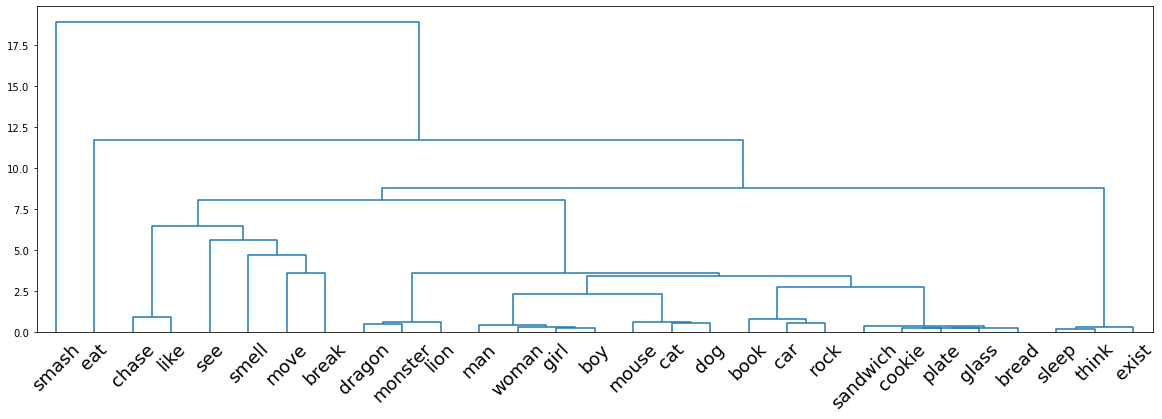

In [8]:
def plot_dendo(X, names, exclude=['<SOS>','<EOS>']):
    #  Show hierarchical clustering of vectors 
    #
    # Input
    #  X : numpy tensor [nitem x dim] such that each row is a vector to be clustered
    #  names : [length nitem] list of item names
    #  exclude: list of names we want to exclude       
    nitem = len(names)
    names  = np.array(names)
    include = np.array([myname not in exclude for myname in names], dtype=bool)
    linked = linkage(X[include],'single', optimal_ordering=True)
    plt.figure(1, figsize=(20,6))
    dendrogram(linked, labels=names[include], color_threshold=0, leaf_font_size=18)
    plt.show()

plot_dendo(rnn.get_embeddings(), unique_tokens)

<div class="alert alert-success" role="alert">
<h3> Problem 3 (10 points) </h3>
<br>
Write a function `generate` to probabilistically sample sentences from your network. Generate 10 sample sentences in this manner. For each, convert the sequence of token indices back to string form. When printing the sentence, you can either include the SOS and EOS or ignore them. It's fine to assume a maximum length.
</div>

**Hint:** You will find `torch.distributions.categorical.Categorical` useful.

In [24]:
def generate(rnn, maxlen=4):
    hid = rnn.initHidden()
    output,hid = rnn.forward(torch.tensor(token_to_index['<SOS>']),hid)
    sentence=['<SOS>']
    for n in range(maxlen-1):
        prob = torch.distributions.categorical.Categorical(output)
        #print(prob)
        next_i = prob.sample()
        next_word = index_to_token[next_i.item()]
        sentence.append(next_word)
        output,hid = rnn.forward(next_i.clone().detach(),hid)
    sentence=" ".join(sentence)
    print(sentence)
    return sentence
                                
for i in range(10):
    generate(rnn)

<SOS> chase mouse sandwich
<SOS> girl like break
<SOS> book dragon boy
<SOS> book girl man
<SOS> cookie monster <EOS>
<SOS> dog book glass
<SOS> smash see see
<SOS> <SOS> <EOS> dragon
<SOS> chase glass see
<SOS> bread dragon rock


/var/folders/h9/pnrvl54x77d7zk45fshg0jhr0000gn/T/ipykernel_28765/4185764537.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = log_softmax(netinput_o)
